First let's import the necessary libraries

In [1]:
import os
import numpy
from fastai.vision import *
import pandas as pd

Let's check the data

In [2]:
path = Path('../input')
path.ls()

[PosixPath('../input/train'),
 PosixPath('../input/test'),
 PosixPath('../input/train.csv'),
 PosixPath('../input/sample_submission.csv')]

In [3]:
train_dir = path/'train'/'train'
test_dir = path/'test'/'test'
train_labels = path/'train.csv'
output = path/'sample_submission.csv'

In [4]:
np.random.seed(26)

In [5]:
data = (ImageList.from_csv(path=path, csv_name='train.csv', folder='train/train')
        .split_by_rand_pct()
        .label_from_df(cols='has_cactus')
        .add_test(ImageList.from_csv(path=path, csv_name='sample_submission.csv', 
                                            folder='test/test'))
        .transform(get_transforms(), size=224)
        .databunch(bs=32, num_workers=0)
        .normalize(imagenet_stats))

In [6]:
# data.show_batch(rows=3, figsize=(10,10))

In [7]:
data.classes, data.classes, data.train_ds, data.test_ds

([0, 1], [0, 1], LabelList (14000 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: CategoryList
 1,1,1,1,0
 Path: ../input, LabelList (4000 items)
 x: ImageList
 Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
 y: EmptyLabelList
 ,,,,
 Path: ../input)

In [8]:
from fastai.vision.learner import create_cnn, models

In [9]:
arch = cnn_learner(data, base_arch=models.resnet34, model_dir='/tmp/models',
                   metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:03, 23051822.01it/s]


In [10]:
arch.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


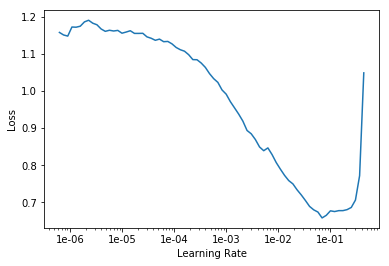

In [11]:
arch.recorder.plot()

In [12]:
epoch = 10
lr = 1e-3

arch.fit_one_cycle(epoch, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.200297,0.090718,0.971143,02:37
1,0.103646,0.043509,0.983714,02:20
2,0.085840,0.033570,0.988000,02:24
3,0.063321,0.024872,0.990571,02:22
4,0.051683,0.017145,0.994857,02:23


In [13]:
arch.save('model-v1')

In [14]:
arch.load('model-v1')

Learner(data=ImageDataBunch;

Train: LabelList (14000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,0
Path: ../input;

Valid: LabelList (3500 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,1,1,0
Path: ../input;

Test: LabelList (4000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../input, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


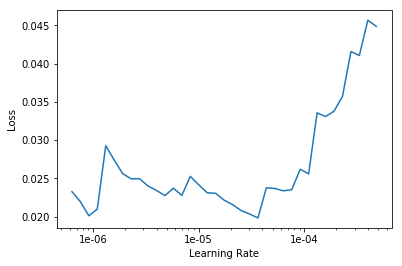

In [15]:
arch.unfreeze()
arch.lr_find()
arch.recorder.plot()

In [16]:
arch.fit_one_cycle(3, max_lr=slice(lr/1000,lr/100))

epoch,train_loss,valid_loss,accuracy,time
0,0.034495,0.013784,0.994571,02:33
1,0.021287,0.008785,0.997429,02:33
2,0.023266,0.008683,0.997429,02:32


In [17]:
prediction, y = arch.get_preds(ds_type=DatasetType.Test)

In [18]:
test_data = pd.read_csv(output)
test_data.has_cactus = prediction.numpy()[:, 0]
test_data.head(10)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1.109435e-04
1,0017242f54ececa4512b4d7937d1e21e.jpg,2.585475e-07
2,001ee6d8564003107853118ab87df407.jpg,9.998192e-01
3,002e175c3c1e060769475f52182583d0.jpg,9.999645e-01
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,2.345510e-03
5,0038ed6f7417b8275b393307f66cb1e3.jpg,2.998571e-05
6,0059dfa41de4441fc23b9a4b98ba99cb.jpg,3.426392e-03
7,0061bd302d735db829418cb90b4e6040.jpg,1.588690e-05
8,00754573d8c7223e73da553dd43780bd.jpg,6.603842e-05
9,008d9fce71c8e03a4c9cdd15ea908573.jpg,9.995989e-01


In [19]:
test_data.to_csv('submission.csv', index=False)